In [186]:
# First we will summarize all the predicition data into household level.
# Use roadservice level data for analysis. 
# Individual level data will be summarized with only predicition
# All the prediction will be combined together on the household level for clustering analysis

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib, re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


# import data
Pred_cancel=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\cancel_out_active.csv")
Pred_Prod=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out.csv")
Pred_RS=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\RS_out.csv")


In [187]:
# Combine 3 dataset together

cancel_list=['Household Key','Pred_Prob_Voluntary_Cancel1']

prod_list=['Household Key','Pred_Prob_CMSI1','Pred_Prob_CC1','Pred_Prob_Deposit1',
           'Pred_Prob_HomeEquity1','Pred_Prob_IDtheft1','Pred_Prob_Mortgage1',
           'Pred_Prob_INS1','Pred_Prob_TRV1']

prod_list1=['Pred_Prob_CMSI1','Pred_Prob_CC1','Pred_Prob_Deposit1',
           'Pred_Prob_HomeEquity1','Pred_Prob_IDtheft1','Pred_Prob_Mortgage1',
           'Pred_Prob_INS1','Pred_Prob_TRV1']

Pred_cancel_HH=Pred_cancel[cancel_list]
Pred_prod_HH=Pred_Prod[prod_list]

Pred_cancel_HH.sort_values(['Household Key']) 
Pred_cancel_HH=pd.pivot_table(data=Pred_cancel_HH, index='Household Key', values=['Pred_Prob_Voluntary_Cancel1'], aggfunc='mean')
Pred_cancel_HH.reset_index()

Pred_prod_HH.sort_values(['Household Key']) 
Pred_prod_HH=pd.pivot_table(data=Pred_prod_HH, index='Household Key', values=prod_list1, aggfunc='mean')
Pred_prod_HH.reset_index()


Pred_cancel_HH = Pred_cancel_HH.sort_values('Household Key', ascending=False)
Pred_prod_HH = Pred_prod_HH.sort_values('Household Key', ascending=False)
Pred_RS = Pred_RS.sort_values('Household Key', ascending=False)

Pred_all=Pred_RS.merge(Pred_cancel_HH,on='Household Key',how='left')
Pred_all=Pred_all.merge(Pred_prod_HH,on='Household Key',how='left')

#Pred_all.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_allcombine_check.csv')

KeyError: "['m_Avg_ERS_ENT_Count_PerYr'] not in index"

In [129]:
# Add two variables  - TOtal # of cars in a household and total # of people

Pred_all['Car Total']=Pred_all['Car_American']+Pred_all['Car_American_Luxury']+Pred_all['Car_European']+Pred_all['Car_European_Luxury']+Pred_all['Car_Japan']+Pred_all['Car_Japan_Luxury']+Pred_all['Car_Other']

Profile_activeset=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\Profile_activeset_noDup.csv")
Indi_set=Profile_activeset[['Household Key','Individual Key']]

Indi_set['Count People'] = 1
Indi_set_forSUM=pd.pivot_table(data=Indi_set, index='Household Key', values=['Count People'], aggfunc='sum')
Indi_set_forSUM.reset_index()

Indi_set_forSUM = Indi_set_forSUM.sort_values('Household Key', ascending=False)
Pred_all = Pred_all.sort_values('Household Key', ascending=False)

Pred_all=Pred_all.merge(Indi_set_forSUM,on='Household Key',how='left')

print(Pred_all[['Car Total','Count People']].describe())

         Car Total  Count People
count  3511.000000   3498.000000
mean      2.158644      1.677244
std       1.637578      0.897142
min       1.000000      1.000000
25%       1.000000      1.000000
50%       2.000000      1.000000
75%       3.000000      2.000000
max      21.000000      7.000000


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [130]:
# normalize the fields that will be used for clustering since we will use probability and cost estimate
# They are on differnt value but we want to keep the distribution there hence normalize instead of stardandize them
var_list=['Pred_Prob_RS_Use1','Pred_CostPerYr','Pred_ExpectedCostPerYr',
'Pred_Prob_Voluntary_Cancel1','Pred_Prob_CC1','Pred_Prob_CMSI1',
          'Pred_Prob_Deposit1','Pred_Prob_HomeEquity1',
          'Pred_Prob_IDtheft1','Pred_Prob_INS1','Pred_Prob_Mortgage1','Pred_Prob_TRV1'
         ]

x=Pred_all[var_list]

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
normalized = pd.DataFrame(x_scaled, columns=var_list)

normalized.dropna(subset=['Pred_Prob_Voluntary_Cancel1'],inplace=True)

#normalized.rename(columns={"0": "Pred_Prob_RS_Use1_norm", "1": "Pred_CostPerYr_norm",
#                          "2": "Pred_ExpectedCostPerYr_norm", "3": "Pred_Prob_Voluntary_Cancel1_norm",
#                         "4": "Pred_Prob_CC1_norm", "5": "Pred_Prob_CMSI1_norm",
#                           "6": "Pred_Prob_Deposit1_norm", "7": "Pred_Prob_HomeEquity1_norm",
#                           "8": "Pred_Prob_IDtheft1_norm", "9": "Pred_Prob_INS1_norm",
#                           "10": "Pred_Prob_Mortgage1", "11": "Pred_Prob_TRV1"},inplace=True)

print(normalized.head())

   Pred_Prob_RS_Use1  Pred_CostPerYr  Pred_ExpectedCostPerYr  \
0           0.820027        0.245171                0.200535   
1           0.618607        0.177134                0.117458   
2           0.661289        0.162740                0.110916   
3           0.898997        0.203412                0.173383   
4           0.375789        0.139039                0.068544   

   Pred_Prob_Voluntary_Cancel1  Pred_Prob_CC1  Pred_Prob_CMSI1  \
0                     0.093902       0.077619         0.724138   
1                     0.504918       0.160427         0.000000   
2                     0.090164       0.335176         0.000000   
3                     0.000000       0.112576         0.729167   
4                     0.022000       0.056067         0.166667   

   Pred_Prob_Deposit1  Pred_Prob_HomeEquity1  Pred_Prob_IDtheft1  \
0                 1.0                    0.0            0.000000   
1                 1.0                    0.0            0.523810   
2             

In [131]:
normalized.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\normalized_check.csv')

In [132]:
print(np.any(np.isnan(normalized)))
print(np.all(np.isfinite(normalized)))

False
True


In [133]:
# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(normalized)
kmeans_6=pd.DataFrame(kmeans.labels_,columns=['kmeans_6']);
print(kmeans_6.head())
print(kmeans_6.describe())

   kmeans_6
0         0
1         1
2         0
3         3
4         2
          kmeans_6
count  3498.000000
mean      2.578902
std       1.848163
min       0.000000
25%       1.000000
50%       2.000000
75%       4.000000
max       5.000000


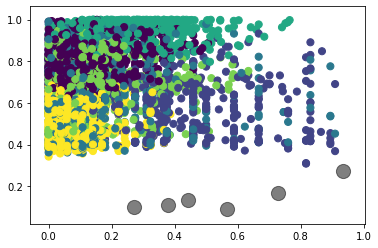

In [134]:
Pred_all.dropna(subset=['Pred_Prob_Voluntary_Cancel1'],inplace=True)
Pred_all.reset_index(inplace=True)
kmeans_6.reset_index(inplace=True)

Pred_all1=Pred_all.merge(kmeans_6,left_index=True,right_index=True)

import matplotlib.pyplot as plt
plt.scatter(Pred_all1['Pred_Prob_Voluntary_Cancel1'],Pred_all1['Pred_Prob_RS_Use1'],
            c=Pred_all1['kmeans_6'], s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [135]:
Pred_all1.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\kmeans6_check.csv')

In [136]:
list_analysis=['Household Key', 'm_PlusMember',
    'Pred_Prob_RS_Use1','Pred_CostPerYr','Pred_ExpectedCostPerYr',
'Pred_Prob_Voluntary_Cancel1','Pred_Prob_CC1','Pred_Prob_CMSI1',
          'Pred_Prob_Deposit1','Pred_Prob_HomeEquity1',
          'Pred_Prob_IDtheft1','Pred_Prob_INS1','Pred_Prob_Mortgage1','Pred_Prob_TRV1',
    'Occ_Blue_Collar', 'Occ_Management', 'Occ_OfficeAdmin',
    'Occ_Professional', 'Occ_Retired', 'Occ_Sales', 'Occ_Technical',
    'Ed_Completed College', 'Ed_Graduated School', 'Ed_High School', 
    'Ed_Some College', 'm_ProfileMissing', 'Car Total','Count People','m_TenureYr', 
    'm_OccupationMissing', 'm_MosJoin2CancelMissing', 'm_AgeMissing',
    'm_IncomeMissing', 'm_CreditMissing', 'm_HomeownerFlag', 'm_RenterFlag',
    'm_memberage',  'm_nChild', 'm_LenResidence',  'm_Income', 'm_Credit', 
    'm_MailRespondYes', 'm_NoChild', 'm_No2DirectMail', 'm_PrimaryMember',  
   'm_AutoRenew', 'Dwell_MFDU', 'Dwell_POBOX', 'Dwell_SFDU', 'm_NewMover',
    'm_ExpensiveModel', 'm_SportsCar', 'Car_American', 'Car_American_Luxury',
    'Car_European', 'Car_European_Luxury', 'Car_Japan', 'Car_Japan_Luxury', 'Car_Other'
]

list_analysis1=['m_PlusMember',
    'Pred_Prob_RS_Use1','Pred_CostPerYr','Pred_ExpectedCostPerYr',
'Pred_Prob_Voluntary_Cancel1','Pred_Prob_CC1','Pred_Prob_CMSI1',
          'Pred_Prob_Deposit1','Pred_Prob_HomeEquity1',
          'Pred_Prob_IDtheft1','Pred_Prob_INS1','Pred_Prob_Mortgage1','Pred_Prob_TRV1',
    'Occ_Blue_Collar', 'Occ_Management', 'Occ_OfficeAdmin',
    'Occ_Professional', 'Occ_Retired', 'Occ_Sales', 'Occ_Technical',
    'Ed_Completed College', 'Ed_Graduated School', 'Ed_High School', 
    'Ed_Some College', 'm_ProfileMissing', 'Car Total','Count People','m_TenureYr', 
    'm_OccupationMissing', 'm_MosJoin2CancelMissing', 'm_AgeMissing',
    'm_IncomeMissing', 'm_CreditMissing', 'm_HomeownerFlag', 'm_RenterFlag',
    'm_memberage',  'm_nChild', 'm_LenResidence',  'm_Income', 'm_Credit', 
    'm_MailRespondYes', 'm_NoChild', 'm_No2DirectMail', 'm_PrimaryMember',  
   'm_AutoRenew', 'Dwell_MFDU', 'Dwell_POBOX', 'Dwell_SFDU', 'm_NewMover',
    'm_ExpensiveModel', 'm_SportsCar', 'Car_American', 'Car_American_Luxury',
    'Car_European', 'Car_European_Luxury', 'Car_Japan', 'Car_Japan_Luxury', 'Car_Other'
]


#Pivot_kmeans6=pd.pivot_table(data=Pred_all1[list_analysis], columns=['kmeans_6'], values=list_analysis1, aggfunc='mean')
summary_kmeans6=Pred_all1.groupby('kmeans_6')[list_analysis1].mean()
summary_kmeans6.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Pivot_kmeans6_check.csv')

In [144]:
print(Pred_all1.groupby('kmeans_6')['Household Key'].nunique())

kmeans_6
0    723
1    396
2    654
3    422
4    464
5    839
Name: Household Key, dtype: int64


   kmeans_5
0         4
1         3
2         4
3         0
4         1
          kmeans_5
count  3498.000000
mean      1.957690
std       1.430072
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
kmeans_5
0    742
1    639
2    930
3    399
4    788
Name: Household Key, dtype: int64


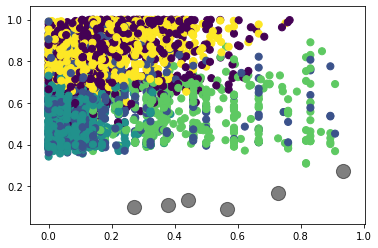

In [145]:
kmeans5 = KMeans(n_clusters=5, random_state=0).fit(normalized)
kmeans_5=pd.DataFrame(kmeans5.labels_,columns=['kmeans_5']);
print(kmeans_5.head())
print(kmeans_5.describe())

kmeans_5.reset_index(inplace=True)

Pred_all1=Pred_all.merge(kmeans_5,left_index=True,right_index=True)

import matplotlib.pyplot as plt
plt.scatter(Pred_all1['Pred_Prob_Voluntary_Cancel1'],Pred_all1['Pred_Prob_RS_Use1'],
            c=Pred_all1['kmeans_5'], s=50, cmap='viridis')


plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#Pivot_kmeans6=pd.pivot_table(data=Pred_all1[list_analysis], columns=['kmeans_6'], values=list_analysis1, aggfunc='mean')
summary_kmeans5=Pred_all1.groupby('kmeans_5')[list_analysis1].mean()
summary_kmeans5.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Pivot_kmeans5_check.csv')

print(Pred_all1.groupby('kmeans_5')['Household Key'].nunique())

   kmeans_4
0         1
1         1
2         1
3         3
4         0
         kmeans_4
count  3498.00000
mean      1.59777
std       1.01983
min       0.00000
25%       1.00000
50%       2.00000
75%       2.00000
max       3.00000
kmeans_4
0     639
1     888
2    1212
3     759
Name: Household Key, dtype: int64


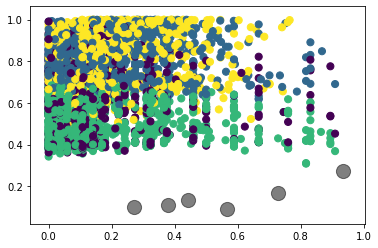

In [146]:
kmeans4 = KMeans(n_clusters=4, random_state=0).fit(normalized)
kmeans_4=pd.DataFrame(kmeans4.labels_,columns=['kmeans_4']);
print(kmeans_4.head())
print(kmeans_4.describe())

kmeans_4.reset_index(inplace=True)

Pred_all1=Pred_all.merge(kmeans_4,left_index=True,right_index=True)

import matplotlib.pyplot as plt
plt.scatter(Pred_all1['Pred_Prob_Voluntary_Cancel1'],Pred_all1['Pred_Prob_RS_Use1'],
            c=Pred_all1['kmeans_4'], s=50, cmap='viridis')

#centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#Pivot_kmeans6=pd.pivot_table(data=Pred_all1[list_analysis], columns=['kmeans_6'], values=list_analysis1, aggfunc='mean')
summary_kmeans4=Pred_all1.groupby('kmeans_4')[list_analysis1].mean()
summary_kmeans4.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Pivot_kmeans4_check.csv')

print(Pred_all1.groupby('kmeans_4')['Household Key'].nunique())

   kmeans_3
0         0
1         0
2         1
3         0
4         2
          kmeans_3
count  3498.000000
mean      0.902516
std       0.765229
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       2.000000
kmeans_3
0    1211
1    1417
2     870
Name: Household Key, dtype: int64


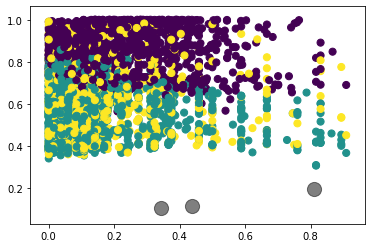

In [147]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized)
kmeans_3=pd.DataFrame(kmeans.labels_,columns=['kmeans_3']);
print(kmeans_3.head())
print(kmeans_3.describe())


kmeans_3.reset_index(inplace=True)

Pred_all1=Pred_all.merge(kmeans_3,left_index=True,right_index=True)

import matplotlib.pyplot as plt
plt.scatter(Pred_all1['Pred_Prob_Voluntary_Cancel1'],Pred_all1['Pred_Prob_RS_Use1'],
            c=Pred_all1['kmeans_3'], s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#Pivot_kmeans6=pd.pivot_table(data=Pred_all1[list_analysis], columns=['kmeans_6'], values=list_analysis1, aggfunc='mean')
summary_kmeans3=Pred_all1.groupby('kmeans_3')[list_analysis1].mean()
summary_kmeans3.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Pivot_kmeans3_check.csv')

print(Pred_all1.groupby('kmeans_3')['Household Key'].nunique())

In [170]:
# Final step for analysis and presentation.
# need to get average age, income, credit ranges on the household level for the ones that 
# are not missing because we assign some values to those fields but we dont it to influence ppt.

Pred_all2=Pred_all.merge(kmeans_6,left_index=True,right_index=True)
Pred_all2=Pred_all2[['Household Key','kmeans_6']]

list_nonmiss1=['Individual Key','Household Key','m_ProfileMissing','m_TenureYr',
               'm_NoChild','m_LenResidence','m_Credit','m_Income'   ]

#'m_nChild' need sum

list_nonmiss2=['Individual Key','Household Key','m_memberage','m_AgeMissing']

Get_nonmissAVG1=Profile_activeset[list_nonmiss1]
Get_nonmissAVG1=Get_nonmissAVG1[Get_nonmissAVG1['m_ProfileMissing']==0]
Get_nonmissAVG1.drop_duplicates(subset =['Household Key','Individual Key'],keep='first', inplace=True)

Get_nonmissAVG1=pd.pivot_table(data=Get_nonmissAVG1, index='Household Key', values=['m_TenureYr','m_NoChild','m_LenResidence','m_Credit','m_Income' ], aggfunc='mean')

Get_nonmissAVG1 = Get_nonmissAVG1.sort_values('Household Key', ascending=False)
Pred_all2 = Pred_all2.sort_values('Household Key', ascending=False)

Pred_all2=Pred_all2.merge(Get_nonmissAVG1,on='Household Key',how='left')
Pred_all2.dropna(subset=['m_TenureYr'],inplace=True)
summary1=Pred_all2.groupby('kmeans_6')['m_TenureYr','m_NoChild','m_LenResidence','m_Credit','m_Income' ].mean()

summary1.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Nonmissing_kmeans6_set1.csv')

###########################################################################
Pred_all2=Pred_all.merge(kmeans_6,left_index=True,right_index=True)
Pred_all2=Pred_all2[['Household Key','kmeans_6']]

Get_nonmissAVG2=Profile_activeset[list_nonmiss2]
#print(Get_nonmissAVG2.head())
Get_nonmissAVG2=Get_nonmissAVG2[Get_nonmissAVG2['m_memberage']>0]
Get_nonmissAVG2.drop_duplicates(subset =['Household Key','Individual Key'],keep='first', inplace=True)

Get_nonmissAVG2=pd.pivot_table(data=Get_nonmissAVG2, index='Household Key', values=['m_memberage'], aggfunc='mean')
Get_nonmissAVG2 = Get_nonmissAVG2.sort_values('Household Key', ascending=False)
Pred_all2 = Pred_all2.sort_values('Household Key', ascending=False)

Pred_all2=Pred_all2.merge(Get_nonmissAVG2,on='Household Key',how='left')


Pred_all2.dropna(subset=['m_memberage'],inplace=True)

summary2=Pred_all2.groupby('kmeans_6')['m_memberage'].mean()

summary2.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Nonmissing_kmeans6_set2.csv')

###########################################################################
Pred_all2=Pred_all.merge(kmeans_6,left_index=True,right_index=True)
Pred_all2=Pred_all2[['Household Key','kmeans_6']]

Get_nonmissAVG3=Profile_activeset[['Individual Key','Household Key','m_ProfileMissing','m_nChild']]
#print(Get_nonmissAVG2.head())
Get_nonmissAVG3=Get_nonmissAVG3[Get_nonmissAVG3['m_ProfileMissing']==0]
Get_nonmissAVG3.drop_duplicates(subset =['Household Key','Individual Key'],keep='first', inplace=True)

Get_nonmissAVG3=pd.pivot_table(data=Get_nonmissAVG3, index='Household Key', values=['m_nChild'], aggfunc='sum')
Get_nonmissAVG3 = Get_nonmissAVG3.sort_values('Household Key', ascending=False)
Pred_all2 = Pred_all2.sort_values('Household Key', ascending=False)

Pred_all2=Pred_all2.merge(Get_nonmissAVG3,on='Household Key',how='left')


Pred_all2.dropna(subset=['m_nChild'],inplace=True)

summary3=Pred_all2.groupby('kmeans_6')['m_nChild'].mean()

summary3.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Nonmissing_kmeans6_set3.csv')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [174]:

count=kmeans_6.groupby('kmeans_6').nunique()

summary_all=pd.concat([count,summary1,summary2,summary3],axis=1)
print(summary_all)

          index  kmeans_6  m_TenureYr  m_NoChild  m_LenResidence    m_Credit  \
kmeans_6                                                                       
0           723         1   35.613212   0.485759       11.807226  729.689610   
1           396         1   36.065718   0.612466       11.390244  729.717480   
2           654         1   38.820952   0.614286       11.623175  718.684762   
3           422         1   29.696632   0.288583       11.584733  726.705074   
4           464         1   37.140566   0.471777       12.272209  731.206761   
5           839         1   43.296349   0.620910       11.896396  715.701043   

               m_Income  m_memberage  m_nChild  
kmeans_6                                        
0         108756.986023    70.590134  1.356013  
1          82017.949864    82.243001  0.686992  
2          82639.520000    76.445469  0.649524  
3         110371.143832    59.625434  2.805774  
4         108829.204796    70.444073  1.790094  
5          81553

kmeans_final
0     723
1     396
2    1493
3     422
4     464
Name: Household Key, dtype: int64


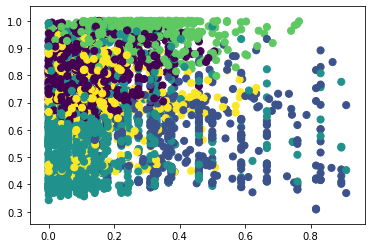

In [180]:
#### Final step on clustering
# Manual tuning on k means 6 group ->Combine 2 & 5 into 2 and output important info for presentation

kmeans_final=kmeans_6.copy()
# take care of the Tenure Years first
def label_k (row):
   if row['kmeans_6'] == 5 :
      return 2
   if row['kmeans_6'] == 0 :
      return 0
   if row['kmeans_6'] == 1 :
      return 1
   if row['kmeans_6'] == 2 :
      return 2
   if row['kmeans_6'] == 3 :
      return 3
   if row['kmeans_6'] == 4 :
      return 4
   return 999
#combine missing & 0 together as they are both not providing info. Very thin vol.

kmeans_final['kmeans_final'] = kmeans_final.apply (lambda row: label_k(row), axis=1)

list_out=[
    'Pred_Prob_RS_Use1','Pred_CostPerYr','Pred_ExpectedCostPerYr','Pred_Prob_Voluntary_Cancel1',
    'Pred_Prob_CC1','Pred_Prob_CMSI1','Pred_Prob_Deposit1','Pred_Prob_HomeEquity1','m_Avg_ERS_ENT_Count_PerYr',
    'Pred_Prob_IDtheft1','Pred_Prob_INS1','Pred_Prob_Mortgage1','Pred_Prob_TRV1','m_PlusMember',
    'Occ_Retired','Car Total','Count People','m_OccupationMissing','m_IncomeMissing',
    'm_CreditMissing','m_HomeownerFlag','m_MailRespondYes','m_PrimaryMember','Dwell_SFDU',
]

kmeans_final.reset_index(inplace=True)

Pred_all_final=Pred_all.merge(kmeans_final,left_index=True,right_index=True)

import matplotlib.pyplot as plt
plt.scatter(Pred_all_final['Pred_Prob_Voluntary_Cancel1'],Pred_all_final['Pred_Prob_RS_Use1'],
            c=Pred_all_final['kmeans_final'], s=50, cmap='viridis')

#centers = kmeans.cluster_centers_

#Pivot_kmeans6=pd.pivot_table(data=Pred_all1[list_analysis], columns=['kmeans_6'], values=list_analysis1, aggfunc='mean')
summary_final=Pred_all_final.groupby('kmeans_final')[list_out].mean()
#summary_kmeans3.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Pivot_kmeans3_check.csv')

print(Pred_all_final.groupby('kmeans_final')['Household Key'].nunique())

In [185]:
# Final step for analysis and presentation.
# need to get average age, income, credit ranges on the household level for the ones that 
# are not missing because we assign some values to those fields but we dont it to influence ppt.

Pred_all2=Pred_all.merge(kmeans_final,left_index=True,right_index=True)
Pred_all2=Pred_all2[['Household Key','kmeans_final']]

list_nonmiss1=['Individual Key','Household Key','m_ProfileMissing','m_TenureYr',
               'm_NoChild','m_LenResidence','m_Credit','m_Income'   ]

#'m_nChild' need sum

list_nonmiss2=['Individual Key','Household Key','m_memberage','m_AgeMissing']

Get_nonmissAVG1=Profile_activeset[list_nonmiss1]
Get_nonmissAVG1=Get_nonmissAVG1[Get_nonmissAVG1['m_ProfileMissing']==0]
Get_nonmissAVG1.drop_duplicates(subset =['Household Key','Individual Key'],keep='first', inplace=True)

Get_nonmissAVG1=pd.pivot_table(data=Get_nonmissAVG1, index='Household Key', values=['m_TenureYr','m_NoChild','m_LenResidence','m_Credit','m_Income' ], aggfunc='mean')

Get_nonmissAVG1 = Get_nonmissAVG1.sort_values('Household Key', ascending=False)
Pred_all2 = Pred_all2.sort_values('Household Key', ascending=False)

Pred_all2=Pred_all2.merge(Get_nonmissAVG1,on='Household Key',how='left')
Pred_all2.dropna(subset=['m_TenureYr'],inplace=True)
summary1=Pred_all2.groupby('kmeans_final')['m_TenureYr','m_NoChild','m_LenResidence','m_Credit','m_Income' ].mean()

summary1.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Nonmissing_kmeansfinal_set1.csv')

###########################################################################
Pred_all2=Pred_all.merge(kmeans_final,left_index=True,right_index=True)
Pred_all2=Pred_all2[['Household Key','kmeans_final']]

Get_nonmissAVG2=Profile_activeset[list_nonmiss2]
#print(Get_nonmissAVG2.head())
Get_nonmissAVG2=Get_nonmissAVG2[Get_nonmissAVG2['m_memberage']>0]
Get_nonmissAVG2.drop_duplicates(subset =['Household Key','Individual Key'],keep='first', inplace=True)

Get_nonmissAVG2=pd.pivot_table(data=Get_nonmissAVG2, index='Household Key', values=['m_memberage'], aggfunc='mean')
Get_nonmissAVG2 = Get_nonmissAVG2.sort_values('Household Key', ascending=False)
Pred_all2 = Pred_all2.sort_values('Household Key', ascending=False)

Pred_all2=Pred_all2.merge(Get_nonmissAVG2,on='Household Key',how='left')


Pred_all2.dropna(subset=['m_memberage'],inplace=True)

summary2=Pred_all2.groupby('kmeans_final')['m_memberage'].mean()

summary2.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Nonmissing_kmeansfinal_set2.csv')

###########################################################################
Pred_all2=Pred_all.merge(kmeans_final,left_index=True,right_index=True)
Pred_all2=Pred_all2[['Household Key','kmeans_final']]

Get_nonmissAVG3=Profile_activeset[['Individual Key','Household Key','m_ProfileMissing','m_nChild']]
#print(Get_nonmissAVG2.head())
Get_nonmissAVG3=Get_nonmissAVG3[Get_nonmissAVG3['m_ProfileMissing']==0]
Get_nonmissAVG3.drop_duplicates(subset =['Household Key','Individual Key'],keep='first', inplace=True)

Get_nonmissAVG3=pd.pivot_table(data=Get_nonmissAVG3, index='Household Key', values=['m_nChild'], aggfunc='sum')
Get_nonmissAVG3 = Get_nonmissAVG3.sort_values('Household Key', ascending=False)
Pred_all2 = Pred_all2.sort_values('Household Key', ascending=False)

Pred_all2=Pred_all2.merge(Get_nonmissAVG3,on='Household Key',how='left')


Pred_all2.dropna(subset=['m_nChild'],inplace=True)

summary3=Pred_all2.groupby('kmeans_final')['m_nChild'].mean()


count=kmeans_final.groupby('kmeans_final').nunique()

summary_all=pd.concat([summary_final,count,summary1,summary2,summary3],axis=1)
print(summary_all)

summary_all.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\summary_final_5groups.csv')

              Pred_Prob_RS_Use1  Pred_CostPerYr  Pred_ExpectedCostPerYr  \
kmeans_final                                                              
0                      0.812363       58.754096               49.296042   
1                      0.569932       34.968885               21.241460   
2                      0.546800       37.425323               22.663100   
3                      0.954138      101.448929               98.331550   
4                      0.699811       29.002600               22.462726   

              Pred_Prob_Voluntary_Cancel1  Pred_Prob_CC1  Pred_Prob_CMSI1  \
kmeans_final                                                                
0                                0.134204       0.084589         0.050751   
1                                0.452832       0.074571         0.027436   
2                                0.123359       0.106044         0.043453   
3                                0.272043       0.054187         0.065937   
4           

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [197]:
# get the average annual count of RS usage for last 3 years 

RS_fullset=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\RoadService_activeset_noDup.csv")

Pred_all4=Pred_all.merge(kmeans_final,left_index=True,right_index=True)
Pred_all4=Pred_all4[['Household Key','kmeans_final']]

Get_nonmissAVG4=RS_fullset[['Household Key','m_Prob_ERS_ENT_Used','m_Avg_ERS_ENT_Count_PerYr']]
#print(Get_nonmissAVG2.head())
Get_nonmissAVG4=Get_nonmissAVG4[Get_nonmissAVG4['m_Prob_ERS_ENT_Used']==1]
Get_nonmissAVG4 = Get_nonmissAVG4.sort_values('Household Key', ascending=False)
Pred_all4 = Pred_all4.sort_values('Household Key', ascending=False)

Pred_all4=Pred_all4.merge(Get_nonmissAVG4,on='Household Key',how='left')

summary4=Pred_all4.groupby('kmeans_final')['m_Avg_ERS_ENT_Count_PerYr'].mean()
print(summary4)
#summary2.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\Nonmissing_kmeansfinal_set2.csv')

kmeans_final
0    2.128573
1    1.634560
2    1.508568
3    2.688877
4    1.333978
Name: m_Avg_ERS_ENT_Count_PerYr, dtype: float64


Pearsons correlation: 0.941


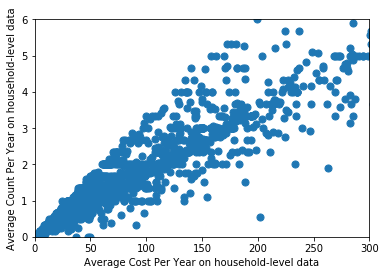

In [198]:
import matplotlib.pyplot as plt

check_Corr=RS_fullset[['Household Key','m_Avg_ERS_Cost_PerYr','m_Avg_ERS_ENT_Count_PerYr']]

plt.xlabel('Average Cost Per Year on household-level data')
plt.ylabel('Average Count Per Year on household-level data')
plt.xlim((0,300))
plt.ylim((0,6))
plt.scatter(RS_fullset['m_Avg_ERS_Cost_PerYr'],RS_fullset['m_Avg_ERS_ENT_Count_PerYr'],
         s=50, cmap='viridis',)

data1=check_Corr[['m_Avg_ERS_Cost_PerYr']]
data2=check_Corr[['m_Avg_ERS_ENT_Count_PerYr']]
from scipy.stats import pearsonr

corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)

In [200]:

import matplotlib.pyplot as plt
plt.scatter(Pred_all2['Count People'],Pred_all2['m_nChild'],
            c=Pred_all2['kmeans_final'], s=50, cmap='viridis')

KeyError: 'Count People'